# Animal Predictor - (Flowers for now)

## Imports

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Sourcing data

In [38]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [39]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


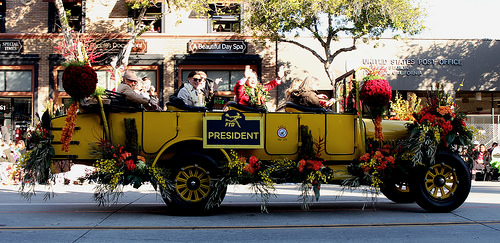

In [40]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

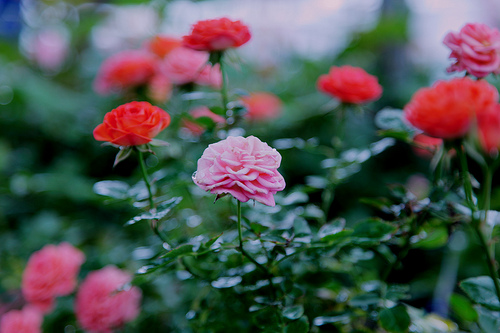

In [41]:
PIL.Image.open(str(roses[1]))

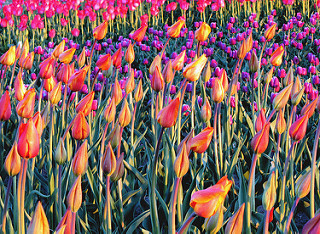

In [42]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

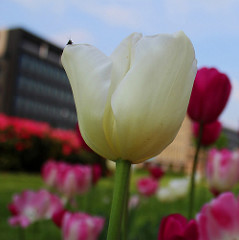

In [43]:
PIL.Image.open(str(tulips[1]))

## Preprocessing images

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [47]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualisation by class

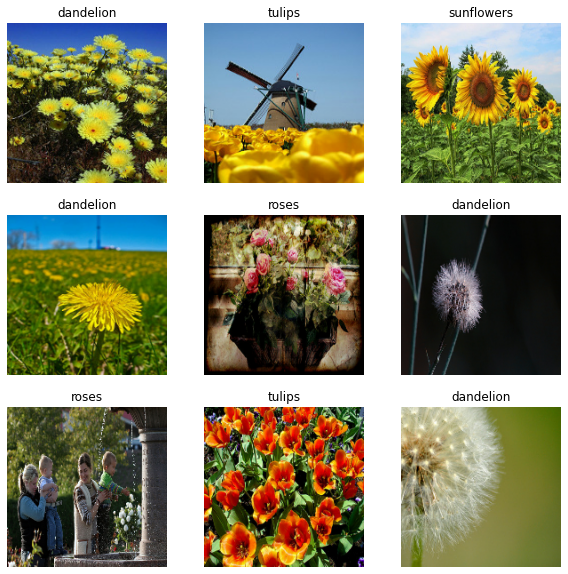

In [48]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configuring dataset for performance

In [49]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [53]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99885625


## Creating the model

In [54]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Getting a model summary

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

## Train the model

In [57]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 31s 335ms/step - loss: 1.4557 - accuracy: 0.3924 - val_loss: 1.0427 - val_accuracy: 0.6008
Epoch 2/10
92/92 [==============================] - 32s 345ms/step - loss: 0.9468 - accuracy: 0.6239 - val_loss: 0.9245 - val_accuracy: 0.6431
Epoch 3/10
92/92 [==============================] - 39s 420ms/step - loss: 0.7328 - accuracy: 0.7333 - val_loss: 0.8588 - val_accuracy: 0.6717
Epoch 4/10
92/92 [==============================] - 32s 349ms/step - loss: 0.5222 - accuracy: 0.8133 - val_loss: 0.8958 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 31s 339ms/step - loss: 0.3180 - accuracy: 0.8866 - val_loss: 1.0450 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 32s 347ms/step - loss: 0.1951 - accuracy: 0.9363 - val_loss: 1.2091 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 31s 335ms/step - loss: 0.1044 - accuracy: 0.9744 - val_loss: 1.4775 - val_accuracy: 0.6744

## Visualise the training results

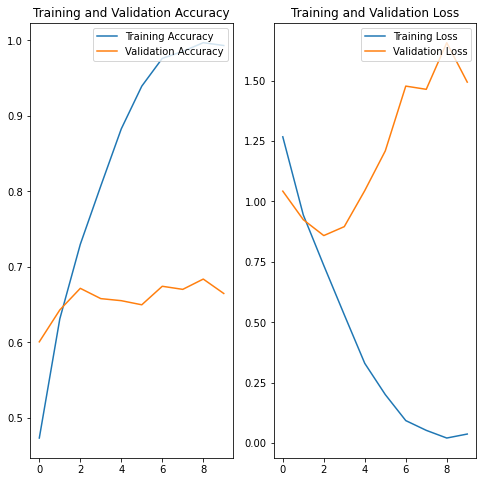

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## What does the above mean?

The above graph indicate the we have suffered from overfitting. This is easy to view in graphical form

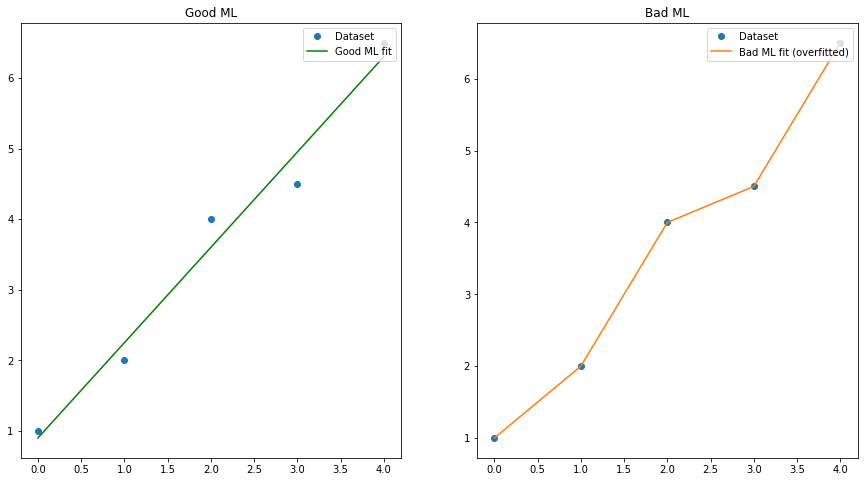

In [102]:
plt.figure(figsize=(15, 8))
x, y = range(5), [1, 2, 4, 4.5, 6.5]
m, b = np.polyfit(x, y, 1)
mx_plus_b = [m * i + b for i in x]
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Dataset', marker='o', linestyle= "")
plt.plot(x, mx_plus_b, label='Good ML fit', color='green', )
plt.legend(loc='upper right')
plt.title('Good ML')

plt.subplot(1, 2, 2)
plt.plot(x, y, label='Dataset', marker='o', linestyle= "")
plt.plot(x, y, label='Bad ML fit (overfitted)')
plt.legend(loc='upper right')
plt.title('Bad ML')
plt.show()